In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from IPython.display import clear_output

import os
import glob
from datetime import datetime, timedelta
import bokeh

# Organize the files by type

In [3]:
data_path = "/Users/toni/data/prop-39-school/prop39-original/"
out_path  = "/Users/toni/data/prop-39-school/prop39-processed/"

In [281]:
# get different data files by type

kwh_files = glob.glob(data_path + '/*/*/*ELECTRIC*INTERVAL*.csv') + \
            glob.glob(data_path + '/*/*/*Electrical*INTERVAL*.csv') + \
            glob.glob(data_path + '/*/*ELECTRIC*INTERVAL*.csv') + \
            glob.glob(data_path + '/*/*/*/*ELECTRIC*INTERVAL*.csv')
gas_files = glob.glob(data_path + '/*/*/*GAS*INTERVAL*.csv') + \
            glob.glob(data_path + '/*/*GAS*INTERVAL*.csv') + \
            glob.glob(data_path + '/*/*/*/*GAS*INTERVAL*.csv')
kwh_bill_files = glob.glob(data_path + '/*/*/*ELECTRIC*BILL*.csv') + \
            glob.glob(data_path + '/*/*/*Electrical*BILL*.csv') + \
            glob.glob(data_path + '/*/*ELECTRIC*BILL*.csv') + \
            glob.glob(data_path + '/*/*/*/*ELECTRIC*BILL*.csv')
gas_bill_files = glob.glob(data_path + '/*/*/*GAS*BILL*.csv') + \
            glob.glob(data_path + '/*/*GAS*BILL*.csv') + \
            glob.glob(data_path + '/*/*/*/*GAS*BILL*.csv')
        
len(kwh_files), len(gas_files), len(kwh_bill_files), len(gas_bill_files)

(9504, 2451, 9504, 2451)

In [90]:
def parse_path(filename):
    basefile = os.path.basename(filename)
    utilityName = f.replace(data_path, "").split("/")[0]
    info = basefile.split("_")
    if len(info) ==6:
        siteId, _, _, serviceType, _, dataType = info
    else:
        # ['30736353030244', '2012-2013', 'ELECTRIC', '20150804.xml', 'INTERVAL.csv']
        siteId, _, serviceType, _, dataType = info
    dataType = dataType.split(".")[0]
    return siteId, utilityName, serviceType, dataType

In [91]:
print kwh_files[0]
parse_path(kwh_files[0])

/Users/toni/data/prop-39-school/prop39-original/SCE/2012-2013/10620260000000_2012-2013_SCE_ELECTRIC_20150722.xml_INTERVAL.csv


('10620260000000', 'SDGE', 'ELECTRIC', 'INTERVAL')

In [92]:
print kwh_files[4000]
parse_path(kwh_files[0])

/Users/toni/data/prop-39-school/prop39-original/PGE/2013-2014/Electricity/44697996108138_20132014_PacificGasElectric_ELECTRIC_20151127.xml_INTERVAL.csv


('10620260000000', 'SDGE', 'ELECTRIC', 'INTERVAL')

In [74]:
print gas_files[0]
parse_path(gas_files[0])

/Users/toni/data/prop-39-school/prop39-original/PGE/2012-2013/Gas/01612590100123_20122013_PacificGasElectric_GAS_20151104.xml_INTERVAL.csv


('01612590100123', 'PacificGasElectric', 'GAS', 'INTERVAL')

In [75]:
print kwh_bill_files[0]
parse_path(kwh_bill_files[0])

/Users/toni/data/prop-39-school/prop39-original/SCE/2012-2013/10620260000000_2012-2013_SCE_ELECTRIC_20150722.xml_BILL.csv


('10620260000000', 'SCE', 'ELECTRIC', 'BILL')

In [76]:
print gas_bill_files[0]
parse_path(gas_bill_files[0])

/Users/toni/data/prop-39-school/prop39-original/PGE/2012-2013/Gas/01612590100123_20122013_PacificGasElectric_GAS_20151104.xml_BILL.csv


('01612590100123', 'PacificGasElectric', 'GAS', 'BILL')

In [140]:
files_df = pd.DataFrame([list(parse_path(f)) + [f] for f in kwh_files + kwh_bill_files + gas_files + gas_bill_files], \
                            columns=["Id", "Utility", "ServiceType", "DataType", "DataFile"])
files_df.head()

,Id,Utility,ServiceType,DataType,DataFile
0,10620260000000,SCE,ELECTRIC,INTERVAL,/Users/toni/data/prop-39-school/prop39-origina...
1,10620266005763,SCE,ELECTRIC,INTERVAL,/Users/toni/data/prop-39-school/prop39-origina...
2,15634040000000,SCE,ELECTRIC,INTERVAL,/Users/toni/data/prop-39-school/prop39-origina...
3,15634040106575,SCE,ELECTRIC,INTERVAL,/Users/toni/data/prop-39-school/prop39-origina...
4,15634040112185,SCE,ELECTRIC,INTERVAL,/Users/toni/data/prop-39-school/prop39-origina...


In [141]:
files_df.shape

(19850, 5)

In [142]:
files_df.set_index(["Id", "Utility", "ServiceType", "DataType"], inplace=True)

# Parse data

### kWh iterval data

In [192]:
def parse_kwh_interval(filename):
    # some files are zero size
    import os
    statinfo = os.stat(filename)
    if statinfo.st_size==0:
        return None
    
    # some files have different number of columns for the first few rows
    i = 0
    ok = False
    while not ok:
        try:
            kwh = pd.read_csv(filename, skiprows=i, header=None)
            ok = True
        except:
            i += 1
    if i>0:
        print "%s: skipped %d lines"%(filename, i)
        
    # all good, format data into canonical
    kwh.rename(columns={0:"id", 1:"date"}, inplace=True)
    # date is in Unix timestamp format, convert to ISO format
    kwh['date'] = kwh['date'].apply(lambda x: datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d'))
    agreement_id = kwh['id'].iloc[0]
    kwh.drop("id", axis=1, inplace=True)
    kwh.set_index(["date"], inplace=True)
    kwh = kwh.iloc[:,:96]
    
    return kwh

In [57]:
kwh = parse_kwh_interval(kwh_files[0])
kwh.head()

15634040000000_2012-2013_SCE_ELECTRIC_20150722.xml_INTERVAL.csv


,2,3,4,5,6,7,8,9,10,11,...,88,89,90,91,92,93,94,95,96,97
date,,,,,,,,,,,,,,,,,,,,,
2012-06-30,0.72,4.32,3.06,0.66,0.60,0.66,0.66,0.72,0.72,0.60,...,0.66,0.60,0.66,0.66,0.66,0.66,0.60,0.66,0.60,0.66
2012-07-01,0.66,0.72,0.66,0.66,0.66,0.72,0.66,0.66,0.72,0.66,...,0.66,0.60,0.66,0.66,0.66,0.60,0.72,0.66,0.60,0.66
2012-07-02,0.72,0.72,0.66,0.66,0.66,0.66,0.66,0.66,0.72,0.72,...,3.60,3.18,3.66,2.88,3.36,3.00,1.44,0.72,0.66,0.66
2012-07-03,0.72,0.66,0.66,0.72,0.66,0.78,0.66,0.72,0.66,0.78,...,0.66,0.60,0.72,0.66,0.66,0.72,0.66,0.66,0.66,0.66
2012-07-04,0.66,0.72,0.66,0.72,0.72,0.78,0.66,0.72,0.66,0.66,...,3.12,3.24,3.66,3.00,2.04,0.78,0.78,0.78,0.78,0.84


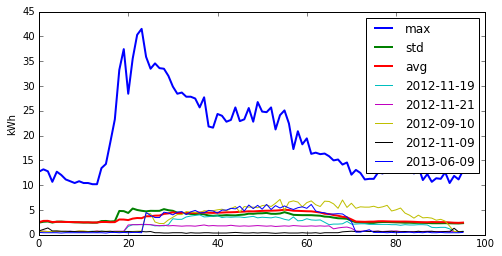

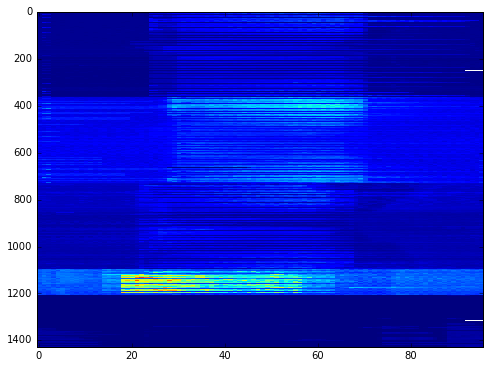

In [59]:
# It looks like this is 15-minute interval data?

plt.figure(figsize=(8,4))
plt.plot(kwh.max().values, label="max", lw=2)
plt.plot(kwh.std().values, label="std", lw=2)
plt.plot(kwh.mean().values, label="avg", lw=2)

idx = np.random.choice(kwh.index.values, 5)
for i in idx:
    plt.plot(kwh.ix[i].values[0], label=i)
    
plt.ylabel("kWh")
plt.legend()

plt.figure(figsize=(8,6))
plt.imshow(kwh.iloc[:,:96].values, interpolation='nearest', aspect='auto')

In [143]:
idx = (files_df.index.get_level_values('ServiceType')=='ELECTRIC') & (files_df.index.get_level_values('DataType')=='INTERVAL')
keys= files_df.index[idx].unique()
print len(keys)

4095


### kWh billing data

In [274]:
def parse_kwh_bill(filename):
    # some files are zero size
    import os
    statinfo = os.stat(filename)
    if statinfo.st_size==0:
        return None
    
    fields = ["cds_code", "start_time", "agreement", "generation", "rate_schedule_id", \
              "n_days", "last_period", "consumption_total"]
    bill = pd.read_csv(filename, usecols=fields, engine='python')
    bill['start_time'] = bill['start_time'].apply(lambda x: np.nan if x in ['false', 'true'] or \
                                                      type(x)==float or (type(x)==str and x.replace(".","").isdigit()) \
                                                            else datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d'))
    bill.dropna(inplace=True)
    bill.set_index("start_time", inplace=True)
    
    return bill

In [283]:
parse_kwh_bill(kwh_bill_files[0])

,cds_code,agreement,rate_schedule_id,n_days,generation,last_period,consumption_total
start_time,,,,,,,
2012-06-11,10620260000000,3449927,GS-1,30,False,21.99,0.0
2012-07-11,10620260000000,3449927,GS-1,30,False,23.10,5.0
2012-08-10,10620260000000,3449927,GS-1,32,False,30.69,36.0
2012-09-11,10620260000000,3449927,GS-1,33,False,34.19,58.0
2012-10-14,10620260000000,3449927,GS-1,30,False,28.02,42.0
2012-11-13,10620260000000,3449927,GS-1,30,False,30.39,60.0
2012-12-13,10620260000000,3449927,GS-1,32,False,32.28,56.0
2013-01-14,10620260000000,3449927,GS-1,29,False,33.00,70.0
2013-02-12,10620260000000,3449927,GS-1,30,False,32.67,62.0


### Gas interval data

<p style="color:red"> All gas interval data files are empty! </p>

In [288]:
from collections import Counter
Counter([os.path.getsize(f) for f in gas_files])

Counter({0: 2451})

### Gas billing data
<p style="color:red"> All gas billing data files are empty! </p>

In [289]:
from collections import Counter
Counter([os.path.getsize(f) for f in gas_bill_files])

Counter({304: 2451})

In [291]:
df = pd.read_csv(gas_bill_files[0])
df.head()

,customer_name,customer_city,customer_zip,customer_account,lea_customer,cds_code,school_site_name,school_city,school_site_zip,agreement,...,generation,start_time,last_period,consumption_total,on_peak,semi_peak,off_peak,on_peak_demand,semi_peak_demand,off_peak_demand


In [292]:
keys[0]

('01612590100123', 'PGE', 'GAS', 'INTERVAL')

### Process all the files

In [197]:
keys = files_df.index.unique()

for i,key in enumerate(keys):
    curId, utilityName, serviceType, dataType = key
    clear_output(wait=True)
    files = files_df.ix[key]['DataFile'].values
    print key, ":", len(files), "files (%d/%d)"%(i,len(keys))
    
    # read data, stitch together
    if serviceType in ['ELECTRIC', 'Electricity'] and dataType == 'INTERVAL':
        func = parse_kwh_interval
    elif serviceType in ['ELECTRIC', 'Electricity'] and dataType == 'BILL':
        func = parse_kwh_bill
    kwh = [func(f) for f in files]
    if len([x for x in kwh if x is None])==len(kwh):
        print "%s: no actual data!"
        continue
    kwh = pd.concat(kwh, axis=0).sort_index()
    
    # save data to disc
    cur_dir = out_path + "/" + utilityName + "/"
    filename= "%s_%s_%s_%s.csv"%(curId, utilityName, serviceType, dataType)
    try:
        os.makedirs(cur_dir)
    except:
        pass
    kwh.to_csv(cur_dir + filename)

('37683380111898', 'SDGE', 'ELECTRIC', 'INTERVAL') : 1 files (3401/4095)
